Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, mu_sin, mu_cos, phi_alpha, phi_sin, phi_cos]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [activity_obs]


Output()

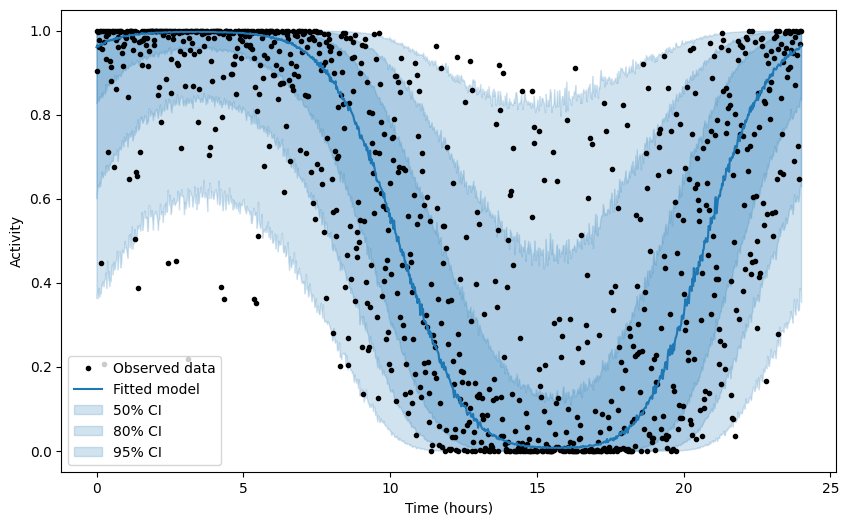

In [5]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pytensor.tensor as pt

# Simulate some example data
np.random.seed(42)
# Time array (e.g., thousands of data points linearly spaced from 0 to 24)
num_points = 1000
time = np.linspace(0, 24, num_points)

# Parameters for the simulation (example values for interesting cyclic pattern)
mu_alpha_true = 0.5
mu_sin_true = 2.0
mu_cos_true = 1.5
phi_alpha_true = 2.0
phi_sin_true = 1.0
phi_cos_true = 0.5

# Linear predictor for mu
linear_mu = mu_alpha_true + mu_sin_true * np.sin(2 * np.pi * time / 24) + mu_cos_true * np.cos(2 * np.pi * time / 24)
mu = 1 / (1 + np.exp(-linear_mu))  # Sigmoid to constrain between 0 and 1

# Linear predictor for phi
linear_phi = phi_alpha_true + phi_sin_true * np.sin(2 * np.pi * time / 24) + phi_cos_true * np.cos(2 * np.pi * time / 24)
phi = np.log1p(np.exp(linear_phi))  # Softplus to constrain to positive values

# Reparameterized alpha and beta for the Beta distribution
alpha_beta = mu * phi
beta_beta = (1 - mu) * phi

# Simulated activity data
activity = np.random.beta(alpha_beta, beta_beta)

# Build and fit the PyMC model with reparameterized Beta distribution
with pm.Model() as model:
    # Priors for unknown model parameters
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=1)
    mu_sin = pm.Normal('mu_sin', mu=2, sigma=1)
    mu_cos = pm.Normal('mu_cos', mu=2, sigma=1)
    
    # Priors for phi parameters
    phi_alpha = pm.Normal('phi_alpha', mu=1, sigma=1)
    phi_sin = pm.Normal('phi_sin', mu=1, sigma=1)
    phi_cos = pm.Normal('phi_cos', mu=0, sigma=1)
    
    # Linear predictor for mu
    linear_mu = mu_alpha + mu_sin * np.sin(2 * np.pi * time / 24) + mu_cos * np.cos(2 * np.pi * time / 24)
    mu = pm.Deterministic('mu', pm.math.sigmoid(linear_mu))
    
    # Linear predictor for phi
    linear_phi = phi_alpha + phi_sin * np.sin(2 * np.pi * time / 24) + phi_cos * np.cos(2 * np.pi * time / 24)
    phi = pm.Deterministic('phi', pt.softplus(linear_phi))
    
    # Reparameterized alpha and beta for the Beta distribution
    alpha_beta = pm.Deterministic('alpha_beta', mu * phi)
    beta_beta = pm.Deterministic('beta_beta', (1 - mu) * phi)
    
    # Likelihood (response variable)
    activity_obs = pm.Beta('activity_obs', alpha=alpha_beta, beta=beta_beta, observed=activity)
    
    # Inference
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)  # Reduced sample size for speed

# Generate predictions over time
post_pred = pm.sample_posterior_predictive(trace, var_names=["activity_obs"], model=model)["posterior_predictive"]

# Plot the data and fitted model
plt.figure(figsize=(10, 6))
plt.plot(time, activity, 'k.', label='Observed data')
plt.plot(time, np.median(post_pred['activity_obs'], axis=(0, 1)), label='Fitted model', color='tab:blue')
plt.fill_between(time, 
                 np.percentile(post_pred['activity_obs'], 25, axis=(0, 1)), 
                 np.percentile(post_pred['activity_obs'], 75, axis=(0, 1)), 
                 color='tab:blue', alpha=0.2, label='50% CI')
plt.fill_between(time, 
                 np.percentile(post_pred['activity_obs'], 10, axis=(0, 1)), 
                 np.percentile(post_pred['activity_obs'], 90, axis=(0, 1)), 
                 color='tab:blue', alpha=0.2, label='80% CI')
plt.fill_between(time, 
                 np.percentile(post_pred['activity_obs'], 2.5, axis=(0, 1)), 
                 np.percentile(post_pred['activity_obs'], 97.5, axis=(0, 1)), 
                 color='tab:blue', alpha=0.2, label='95% CI')
plt.xlabel('Time (hours)')
plt.ylabel('Activity')
plt.legend()
plt.savefig("periodic_beta_fit.pdf", bbox_inches="tight")
plt.show()
